# Kaggle - LLM Science Exam
> Use LLMs to answer difficult science questions

<img src="https://www.kaggle.com/competitions/54662/images/header">

# 🎯 | Motivation

* In this notebook, we will demonstrate the usage of the multi-backend capabilities of `KerasCore` and `KerasNLP` for the **MultipleChoice** task. Our aim is to provide a comprehensive guide to building a **MultipleChoice** model using pre-trained NLP models from the `KerasNLP` library.
* While there are already numerous notebooks showcasing how to employ popular models like `Bert/Deberta` with `AutoModelForMultipleChoice` from **HuggingFace**, these notebooks excel in quick training and inference. However, understanding the inner workings of the model might be challenging for those new to the HF library. Our notebook seeks to offer a deeper insight into constructing a **MultipleChoice** model using pre-trained NLP models from the `KerasNLP` library.
* Thanks to to `KerasCore`, which enables seamless execution of this notebook on `TensorFlow`, `Jax`, and `PyTorch` platforms with minimal adjustments required.
* Moreover, this notebook accommodates both Single/Multi GPU and TPU training. As time progresses, larger datasets may become available, making TPUs invaluable for training substantial models on these extensive datasets.

# 📌 | Updates
* `v19` - `DebertaV3Base` - `torch` backed in GPU
* `v11` - `DebertaV3Base` English model
* `v10` - Fix `ShuffleOption` augmentation; answers need to be shuffled in same order
* `v09` - TPU with `jax` backed but low lr
* `v08` - TPU with `jax` backend

# 🛠 | Install Libraries 

In [ ]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons

# 📚 | Import Libraries 

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # or "tensorflow" or "torch"
os.environ["WANDB_SILENT"] = "false" # for wandb

import keras_nlp
import keras_core as keras 
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

## Library Version

In [ ]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

# ⚙️ | Configuration

In [ ]:
class CFG:
    verbose = 0  # Verbosity
    
    wandb = True  # Weights & Biases logging
    competition = 'kaggle-llm-science-exam'  # Competition name
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description
    
    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    
    device = 'TPU'  # Device
    
    seed = 42  # Random seed
    
    num_folds = 5  # Total folds
    selected_folds = [1, 2]  # Folds to train on
    
    epochs = 10  # Training epochs
    batch_size = 2  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    augment = True # Augmentation (Shuffle Options)
    
    scheduler = 'cosine'  # Learning rate scheduler
    
    external_data = True  # External data flag
    
    class_names = list("ABCDE")  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [ ]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU). 

In [ ]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [ ]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

# 📁 | Dataset Path 

In [ ]:
BASE_PATH = '/kaggle/input/kaggle-llm-science-exam'

# 📖 | Meta Data 
* **train.csv** - a set of 200 questions with the answer column. Each question consists of a `prompt` (the question), 5 options labeled `A`, `B`, `C`, `D`, and `E`, and the correct answer labeled `answer` (this holds the label of the most correct answer, as defined by the generating LLM).
* **test.csv** - similar to train.csv except it doesn't have `answer` column.  It has ~4000 questions that may be different is subject matter.
* **sample_submission.csv** - is the valid sample submission.
    * `id`: number id of the question
    * `prediction`: top 3 labels for your prediction. Once a correct label has been scored for an individual question in the test set, that label is no longer considered relevant for that question, and additional predictions of that label are skipped in the calculation

## Train Data

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')  # Read CSV file into a DataFrame
df['label'] = df.answer.map(CFG.name2label)  # Map answer labels using name-to-label mapping

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.answer.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Answer")
plt.ylabel("Count")
plt.title("Answer distribution for Train Data")
plt.show()


## External Datasets

We'll be utilizing the following external datasets:

1. [mozattt's dataset](https://www.kaggle.com/datasets/mozattt/llm-science-3k-data)
2. [leonidkulyk's dataset](https://www.kaggle.com/datasets/leonidkulyk/wikipedia-stem-1k)
3. [radek's dataset](https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam)


In [ ]:
# Concatenate multiple external datasets into one DataFrame
ext_df = pd.concat([
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv'),
#     pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv'),
#     pd.read_csv('/kaggle/input/llm-science-3k-data/test.csv'),
#     pd.read_csv('/kaggle/input/wikipedia-stem-1k/stem_1k_v1.csv')
])

# ext_df.drop(columns=["id"], inplace=True)  # Drop 'id' column
ext_df.reset_index(drop=True, inplace=True)  # Reset index
ext_df["id"] = ext_df.index.tolist()  # Add 'id' column as index
ext_df['label'] = ext_df.answer.map(CFG.name2label)  # Map answer labels using name-to-label mapping

# Display information about the external data
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.answer.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Answer")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

## Contextualize Options

Our approach entails furnishing the model with question and answer pairs, as opposed to employing a single question for all five options. In practice, this signifies that for the five options, we will supply the model with the same set of five questions combined with each respective answer choice (e.g., `(Q + A)`, `(Q + B)`, and so on). This analogy draws parallels to the practice of revisiting a question multiple times during an exam to promote a deeper understanding of the problem at hand.

In [ ]:
# Define a function to create options based on the prompt and choices
def make_options(row):
    row['options'] = [f"{row.prompt}\n{row.A}",  # Option A
                      f"{row.prompt}\n{row.B}",  # Option B
                      f"{row.prompt}\n{row.C}",  # Option C
                      f"{row.prompt}\n{row.D}",  # Option D
                      f"{row.prompt}\n{row.E}"]  # Option E
    return row


In [ ]:
df = df.apply(make_options, axis=1)  # Apply the make_options function to each row in df
df.head(2)  # Display the first 2 rows of df

ext_df = ext_df.apply(make_options, axis=1)  # Apply the make_options function to each row in ext_df
ext_df.head(2)  # Display the first 2 rows of ext_df

# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `answer` column.

It's worth noting that external data will not find usage in the validation phase. Instead, for every fold, the external data will only contribute to the training process. To elaborate, consider the scenario of `fold0` training:
- **Training data:** fold1, fold2, fold3, external
- **Validation data:** fold0

In [ ]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['answer'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "answer"]).size()

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [ ]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🌈 | Augmentation

## OptionShuffle

In this notebook, we'll experiment with an interesting augmentation technique, `OptionShuffle`. Since we're providing the model with one option at a time, we can introduce a shuffle to the order of options. For instance, options `[A, C, E, D, B]` would be rearranged as `[D, B, A, E, C]`. This practice will help the model focus on the content of the options themselves, rather than being influenced by their positions.

In [ ]:
def OptionShuffle(options, labels, prob=0.50, seed=None):
    if tf.random.uniform([]) > prob:  # Shuffle probability check
        return options, labels
    # Shuffle indices of options and labels in the same order
    indices = tf.random.shuffle(tf.range(tf.shape(options)[0]), seed=seed)
    # Shuffle options and labels
    options = tf.gather(options, indices)
    labels = tf.gather(labels, indices)
    return options, labels

In the following function, we'll merge all augmentation functions to apply to the text. These augmentations will be applied to the data using the `dataset.map(augment_fn)` approach.

In [ ]:
def augment_fn(text, label=None):
    text, label = OptionShuffle(text, label, prob=0.5)  # Apply OptionShuffle
    return (text, label) if label is not None else text

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  augment=False, repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=5))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    if augment:  # Apply augmentation if enabled
        ds = ds.map(augment_fn, num_parallel_calls=AUTO)
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [ ]:
def get_datasets(fold):
    train_df = df.query("fold!=@fold")  # Get training fold data
    
    if CFG.external_data:
        train_df = pd.concat([train_df, ext_df], axis=0)  # Add external data texts
        train_df = train_df.reset_index(drop=True)
        
    train_texts = train_df.options.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True, augment=CFG.augment)

    valid_df = df.query("fold==@fold")  # Get validation fold data
    valid_texts = valid_df.options.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False, augment=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

# 🪄 | Wandb
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To monitor the training of my text-based model, I'll make use of **Weights & Biases**. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development. 

In [ ]:
import wandb  # Import wandb library for experiment tracking
import wandb_addons # Additional wandb utilities

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

## Logger

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic `WandbCallback`, making it easier to use. Here's a brief introduction to them:

* **WandbModelCheckpoint**: This callback saves the model or weights using `tf.keras.callbacks.ModelCheckpoint`. Hence, we can harness the power of the official TensorFlow callback to log even `tf.keras.Model` subclass model in TPU.
* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.
* **WandbEvalCallback**: This one is even more special. We can use it to log the model's prediction after a certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to check intermediate results and so on.

For more details, please check the [official documentation](https://docs.wandb.ai/ref/python/integrations/keras).

In [ ]:
from wandb_addons.keras import WandbMetricsLogger
from wandb_addons.keras import WandbModelCheckpoint


# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-science-exam-public",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_acc': best_acc, 'best_acc@3': best_acc3,
               'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_ckpt = WandbModelCheckpoint(f'fold{fold}.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max')
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr, wb_ckpt]  # Return WandB callbacks


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [ ]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# ☎️ | Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`, `model_checkpoint`, `wandb_logger`, and etc.

In [ ]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_accuracy',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

# 🤖 | Modeling



## KerasNLP Classifier

<img src="https://keras.io/img/logo.png" width="400">

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DistillBert`. However, feel free to explore all available models in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). Also for a deeper understanding of `KerasNLP`, refer to the informative [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.XXClassifier` to process each question and option pari (e.g. (Q+A), (Q+B), etc.), generating logits. These logits are then combined and passed through a softmax function to produce the final output.

## Classifier for Multiple-Choice Tasks

When dealing with multiple-choice questions, instead of giving the model the question and all options together `(Q + A + B + C ...)`, we provide the model with one option at a time along with the question. For instance, `(Q + A)`, `(Q + B)`, and so on. Once we have the prediction scores (logits) for all options, we combine them using the `Softmax` function to get the ultimate result. If we had given all options at once to the model, the text's length would increase, making it harder for the model to handle. The picture below illustrates this idea:

![Model Diagram](https://pbs.twimg.com/media/F3NUju_a8AAS8Fq?format=png&name=large)

<div align="center"><b> Picture Credict: </b> <a href="https://twitter.com/johnowhitaker"> @johnowhitaker </a> </div></div><br>

From a coding perspective, remember that we use the same model for all five options, with shared weights. Despite the figure suggesting five separate models, they are, in fact, one model with shared weights. Another point to consider is the the input shapes of Classifier and MultipleChoice.

* Input shape for **Multiple Choice**: $(batch\_size, num\_choices, seq\_length)$
* Input shape for **Classifier**: $(batch\_size, seq\_length)$

Certainly, it's clear that we can't directly give the data for the multiple-choice task to the model because the input shapes don't match. To handle this, we'll use **slicing**. This means we'll separate the features of each option, like $feature_{(Q + A)}$ and $feature_{(Q + B)}$, and give them one by one to the NLP classifier. After we get the prediction scores $logits_{(Q + A)}$ and $logits_{(Q + B)}$ for all the options, we'll use the Softmax function, like $\operatorname{Softmax}([logits_{(Q + A)}, logits_{(Q + B)}])$, to combine them. This final step helps us make the ultimate decision or choice.

> Note that in the classifier, we set `num_classes=1` instead of `5`. This is because the classifier produces a single output for each option. When dealing with five options, these individual outputs are joined together and then processed through a softmax function to generate the final result, which has a dimension of `5`.

In [ ]:
# Selects one option from five
class SelectOption(keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        # Selects a specific slice from the inputs tensor
        return inputs[:, self.index, :]
    
    def get_config(self):
        # For serialize the model
        base_config = super().get_config()
        config = {
            "index": self.index,
        }
        return {**base_config, **config}

def build_model():
    # Define input layers
    inputs = {
        "token_ids": keras.Input(shape=(5, None), dtype=tf.int32, name="token_ids"),
        "padding_mask": keras.Input(shape=(5, None), dtype=tf.int32, name="padding_mask"),
    }
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    logits = []
    # Loop through each option (Q+A), (Q+B) etc and compute associted logits
    for option_idx in range(5):
        option = {k: SelectOption(option_idx, name=f"{k}_{option_idx}")(v) for k, v in inputs.items()}
        logit = classifier(option)
        logits.append(logit)
        
    # Compute final output
    logits = keras.layers.Concatenate(axis=-1)(logits)
    outputs = keras.layers.Softmax(axis=-1)(logits)
    model = keras.Model(inputs, outputs)
    
    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(k=3, name="accuracy@3")
        ],
        jit_compile=True
    )
    return model

In [ ]:
# with strategy.scope
model = build_model()

### Model Summary

In [ ]:
model.summary()

### Model Plot

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# 🚂 | Training

In [ ]:
for fold in CFG.selected_folds:
    # Initialize Weights and Biases if enabled
    if CFG.wandb:
        run = wandb_init(fold)

    # Get train and validation datasets
    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    
    # Get callback functions for training
    callbacks = get_callbacks(fold)

    # Print training information
    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)
    
    # Clear TensorFlow session and build the model within the strategy scope
    K.clear_session()
    with strategy.scope():
        model = build_model()

    # Start training the model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )
    
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc = history.history['val_accuracy'][best_epoch]
    best_acc3 = history.history['val_accuracy@3'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> Best Acc@3 : {best_acc3:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)
    
    # Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        log_wandb()  # Log results
        wandb.run.finish()  # Finish the run
#         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
    print("\n\n")

## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/llm-science-exam-public) to check all the training logs in **WandB** dashboard.

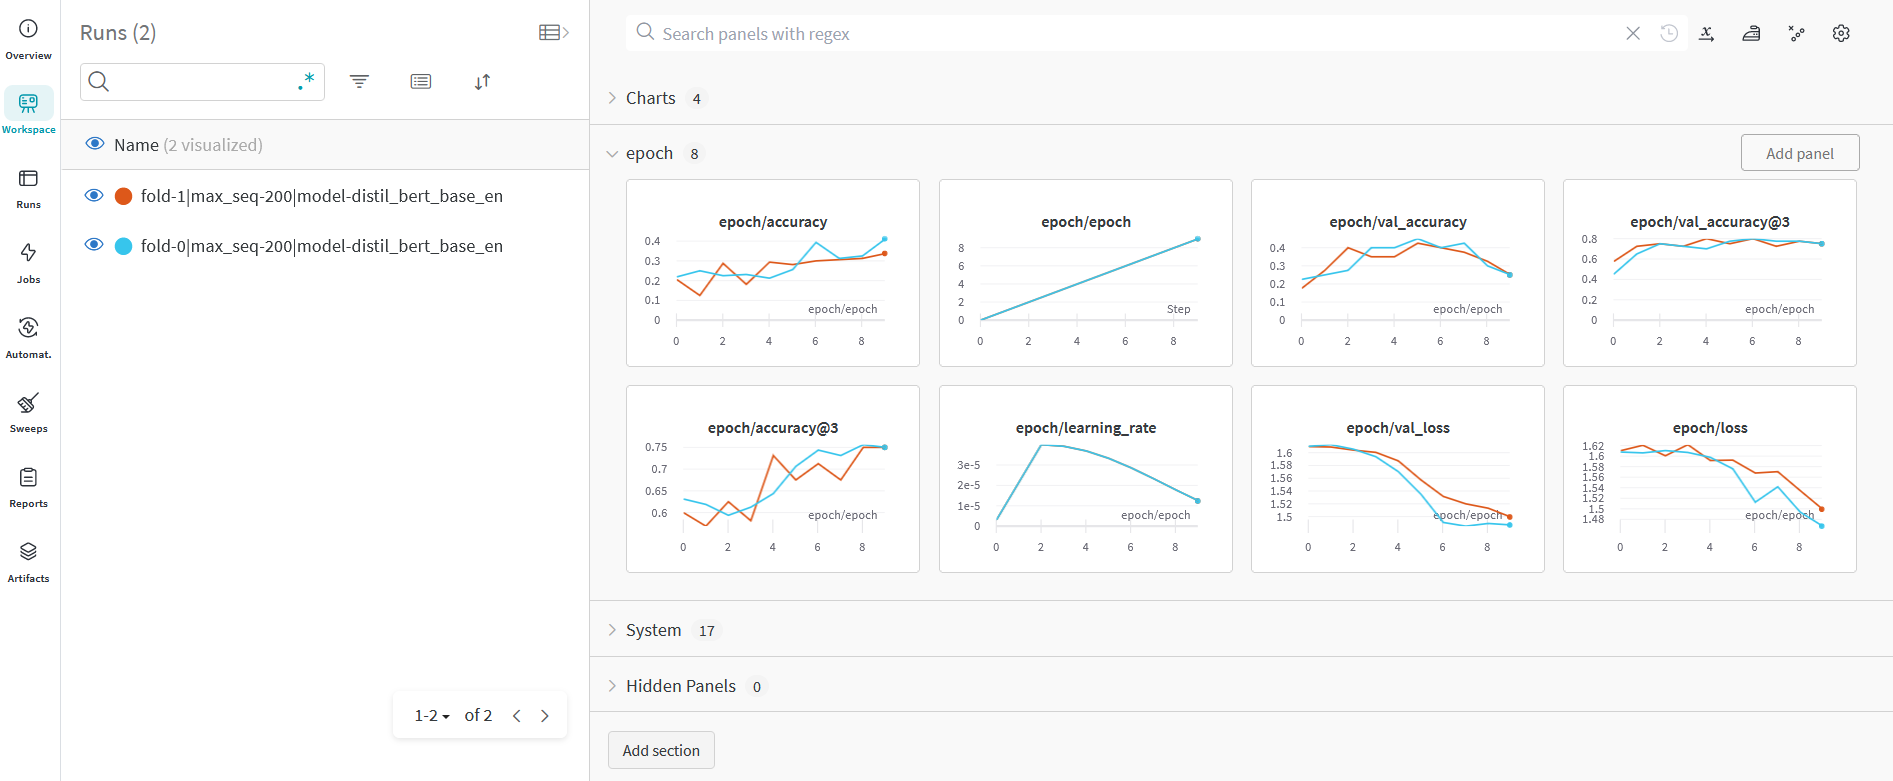

# 🧪 | Prediction

In [ ]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)), # max batch size = valid size
    verbose=1
)

In [ ]:
# Format predictions and true answers
pred_answers = np.array(list('ABCDE'))[np.argsort(-predictions)][:, 0]
true_answers = valid_df.answer.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    question  = row.prompt
    pred_answer = pred_answers[i]
    true_answer = true_answers[i]
    print(f"❓ Question {i+1}:\n{question}\n")
    print(f"✅ True Answer: {true_answer}\n   >> {row[true_answer]}\n")
    print(f"🤖 Predicted Answer: {pred_answer}\n   >> {row[pred_answer]}\n")
    print("-"*90, "\n")

# ✍️ | Reference
* [Multiple Choice with HF](https://twitter.com/johnowhitaker/status/1689790373454041089?s=20) @johnowhitaker
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [BirdCLEF23: Pretraining is All you Need [Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train) by @awsaf49
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte

In [ ]:
!rm -r /kaggle/working/wandb  